In [21]:
!pip install statsmodels

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [23]:
# Load the data
df = pd.read_csv('./Data/yearwise_FEE_Rupee.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Year,FEE_Rupee_Crore,PercentChangeoverPreviousYear
0,2001,15083,-3.5
1,2002,15064,-0.1
2,2003,20729,37.6
3,2004,27944,34.8
4,2005,33123,18.5


In [24]:
# Check the data types and basic info
print("\nDataset info:")
df.info()

# Check for missing values
print("\nMissing values count:")
df.isnull().sum()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           23 non-null     int64  
 1   FEE_Rupee_Crore                23 non-null     int64  
 2   PercentChangeoverPreviousYear  23 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 684.0 bytes

Missing values count:


Year                             0
FEE_Rupee_Crore                  0
PercentChangeoverPreviousYear    0
dtype: int64

In [25]:
# Basic statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,Year,FEE_Rupee_Crore,PercentChangeoverPreviousYear
count,23.00000,23.000000,23.000000
mean,2012.00000,96212.826087,17.500000
std,6.78233,67311.233575,38.246901
min,2001.00000,15064.000000,-55.800000
25%,2006.50000,41693.500000,10.200000
50%,2012.00000,83036.000000,14.300000
75%,2017.50000,144495.000000,20.800000
max,2023.00000,231927.000000,165.600000


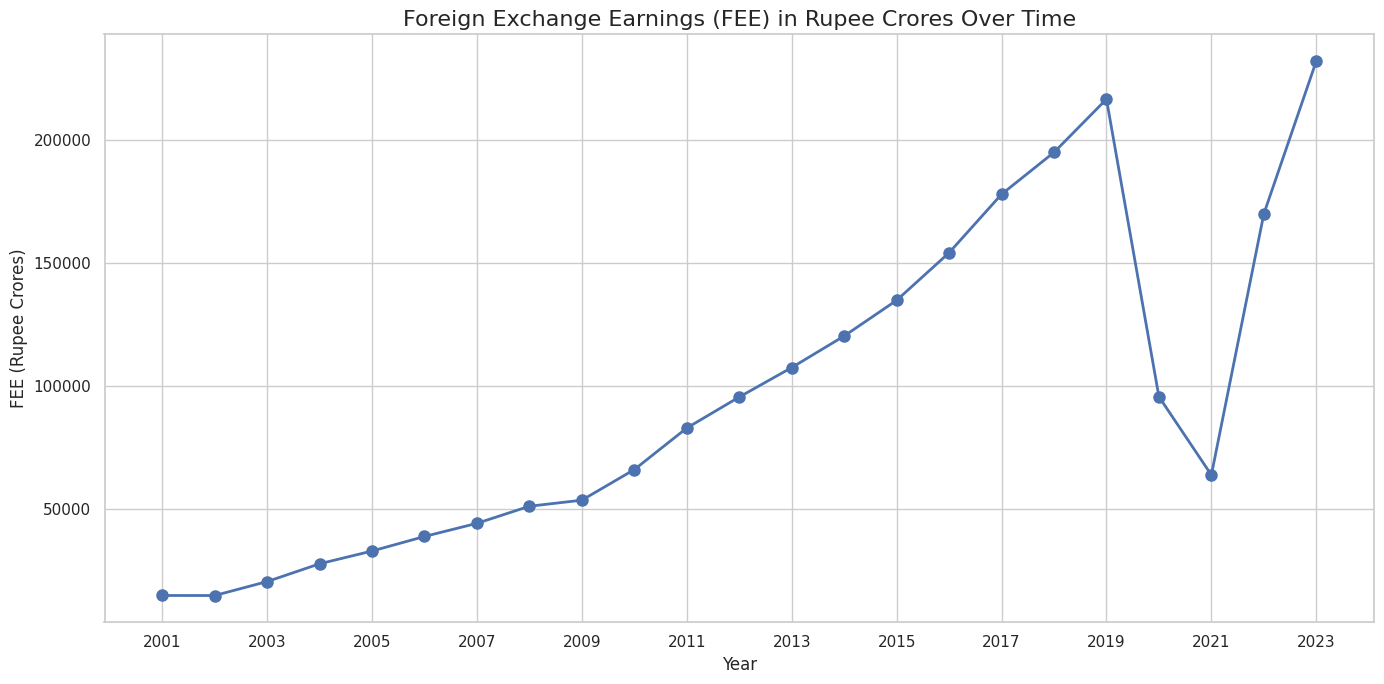

In [26]:
# Set Year as the index for time series analysis
df_ts = df.copy()
df_ts.set_index('Year', inplace=True)

# Plot the FEE values over time
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Foreign Exchange Earnings (FEE) in Rupee Crores Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.grid(True)
plt.xticks(df_ts.index[::2])  # Show every other year for clarity
plt.tight_layout()
plt.show()

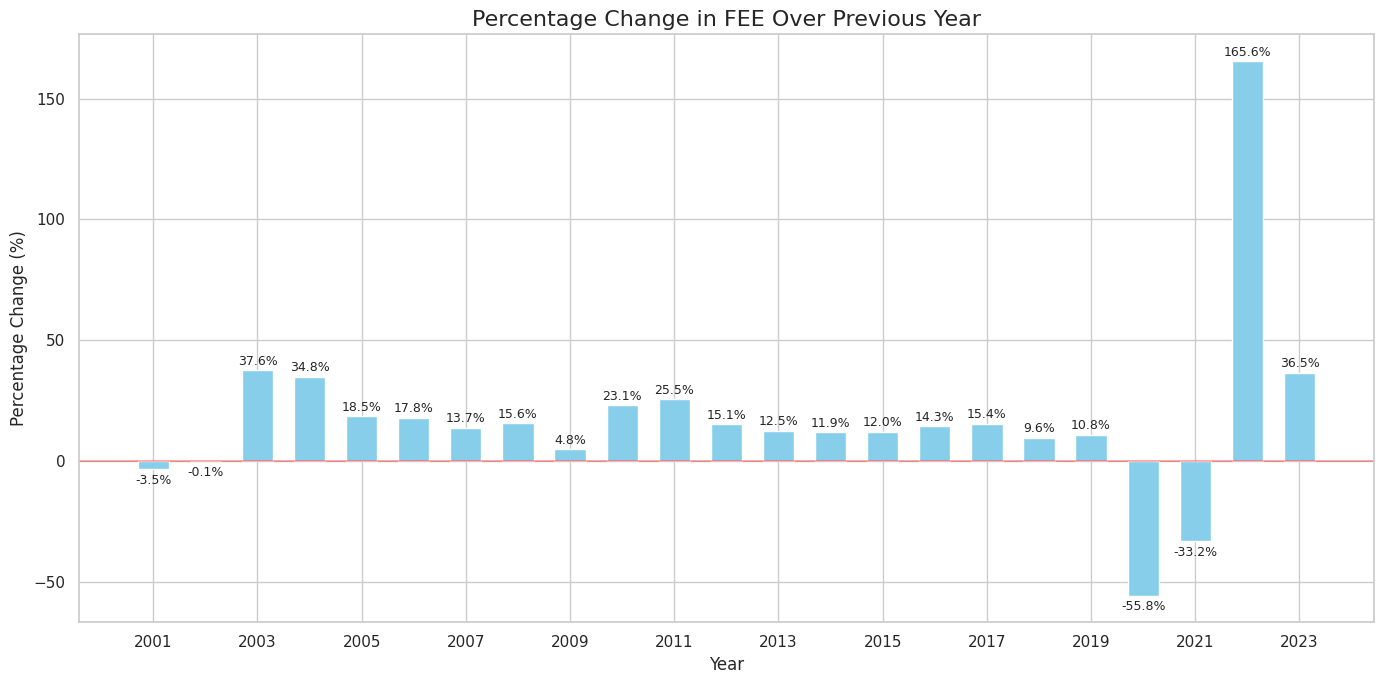

In [ ]:
# Plot the percentage change over previous year
plt.figure(figsize=(14, 7))
plt.bar(df_ts.index, df_ts['PercentChangeoverPreviousYear'], color='skyblue', width=0.6)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
plt.title('Percentage Change in FEE Over Previous Year', fontsize=16)
plt.xlabel('Year', fontsize=a12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.grid(True, axis='y')
plt.xticks(df_ts.index[::2])  # Show every other year for clarity
for i, v in enumerate(df_ts['PercentChangeoverPreviousYear']):
    if not np.isnan(v):  # Skip NaN values
        plt.text(df_ts.index[i], v + (1 if v > 0 else -2), f'{v:.1f}%', 
                 ha='center', va='bottom' if v > 0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()

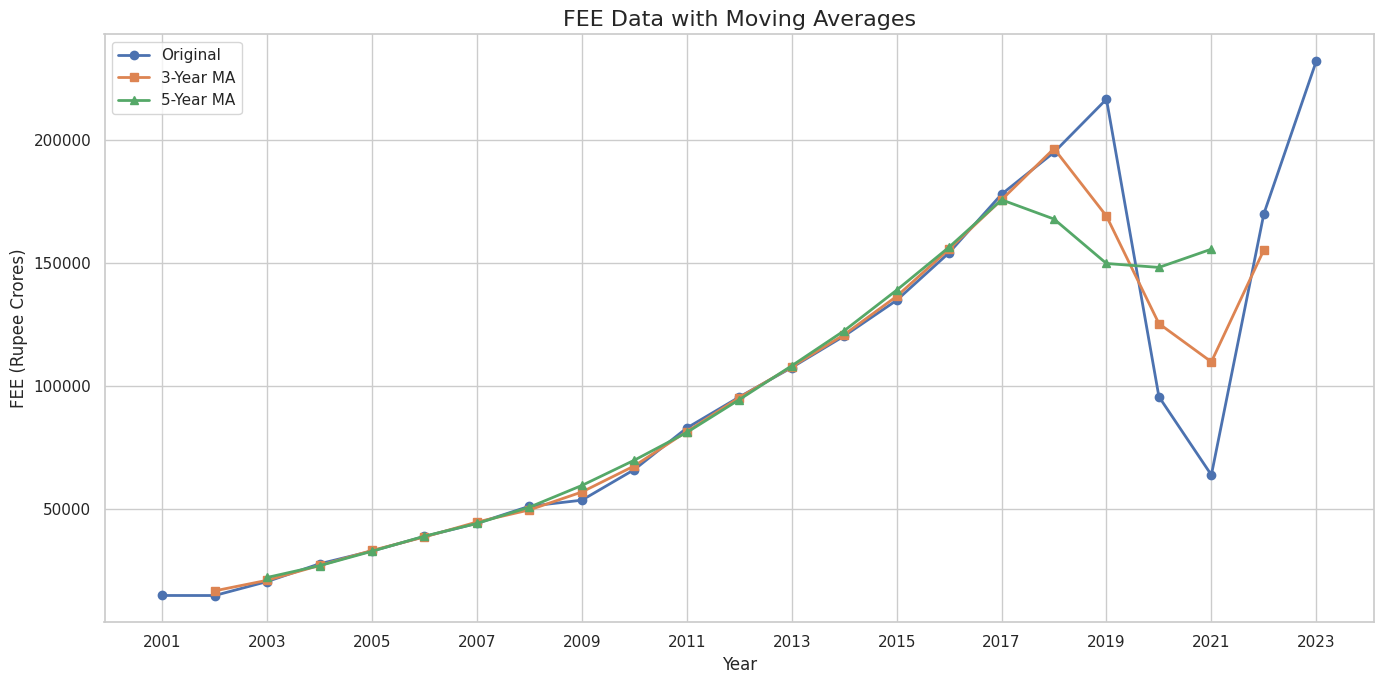

In [28]:
# Since we don't have seasonal data (only yearly), we'll focus on the trend
# Apply moving average to isolate the trend
df_ts['MA_3'] = df_ts['FEE_Rupee_Crore'].rolling(window=3, center=True).mean()
df_ts['MA_5'] = df_ts['FEE_Rupee_Crore'].rolling(window=5, center=True).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', label='Original', linewidth=2)
plt.plot(df_ts.index, df_ts['MA_3'], marker='s', label='3-Year MA', linewidth=2)
plt.plot(df_ts.index, df_ts['MA_5'], marker='^', label='5-Year MA', linewidth=2)
plt.title('FEE Data with Moving Averages', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(df_ts.index[::2])
plt.tight_layout()
plt.show()

In [29]:
# Define time periods for analysis
# Assuming the data spans multiple decades, we'll divide it into periods
min_year = df_ts.index.min()
max_year = df_ts.index.max()

# Create time periods (adjust based on actual data span)
period_ranges = []
current_start = min_year
period_length = 5  # 5-year periods

while current_start <= max_year:
    period_end = min(current_start + period_length - 1, max_year)
    period_ranges.append((current_start, period_end))
    current_start = period_end + 1

# Calculate statistics for each period
period_stats = []

for start_year, end_year in period_ranges:
    period_data = df_ts.loc[start_year:end_year, 'FEE_Rupee_Crore']
    period_growth = df_ts.loc[start_year:end_year, 'PercentChangeoverPreviousYear'].dropna()
    
    stats = {
        'Period': f"{start_year}-{end_year}",
        'Average FEE (Crore)': period_data.mean(),
        'CAGR (%)': ((period_data.iloc[-1] / period_data.iloc[0]) ** (1 / (end_year - start_year)) - 1) * 100 if len(period_data) > 1 else np.nan,
        'Avg Annual Growth (%)': period_growth.mean() if len(period_growth) > 0 else np.nan,
        'Volatility (%)': period_growth.std() if len(period_growth) > 1 else np.nan,
        'Min FEE (Crore)': period_data.min(),
        'Max FEE (Crore)': period_data.max(),
        'Range (Crore)': period_data.max() - period_data.min(),
    }
    period_stats.append(stats)

# Create a summary DataFrame
summary_periods_df = pd.DataFrame(period_stats)
summary_periods_df.set_index('Period', inplace=True)

# Display the summary statistics by period
print("FEE Summary Statistics by Period:")
summary_periods_df.round(2)

FEE Summary Statistics by Period:


,Average FEE (Crore),CAGR (%),Avg Annual Growth (%),Volatility (%),Min FEE (Crore),Max FEE (Crore),Range (Crore)
Period,,,,,,,
2001-2005,22388.6,21.73,17.46,19.07,15064,33123,18059
2006-2010,50921.4,14.11,15.00,6.70,39025,66172,27147
2011-2015,108283.4,12.89,15.40,5.79,83036,134844,51808
2016-2020,167821.2,-11.23,-1.14,30.65,95738,216467,120729
2021-2023,155274.0,90.40,56.30,100.87,63978,231927,167949


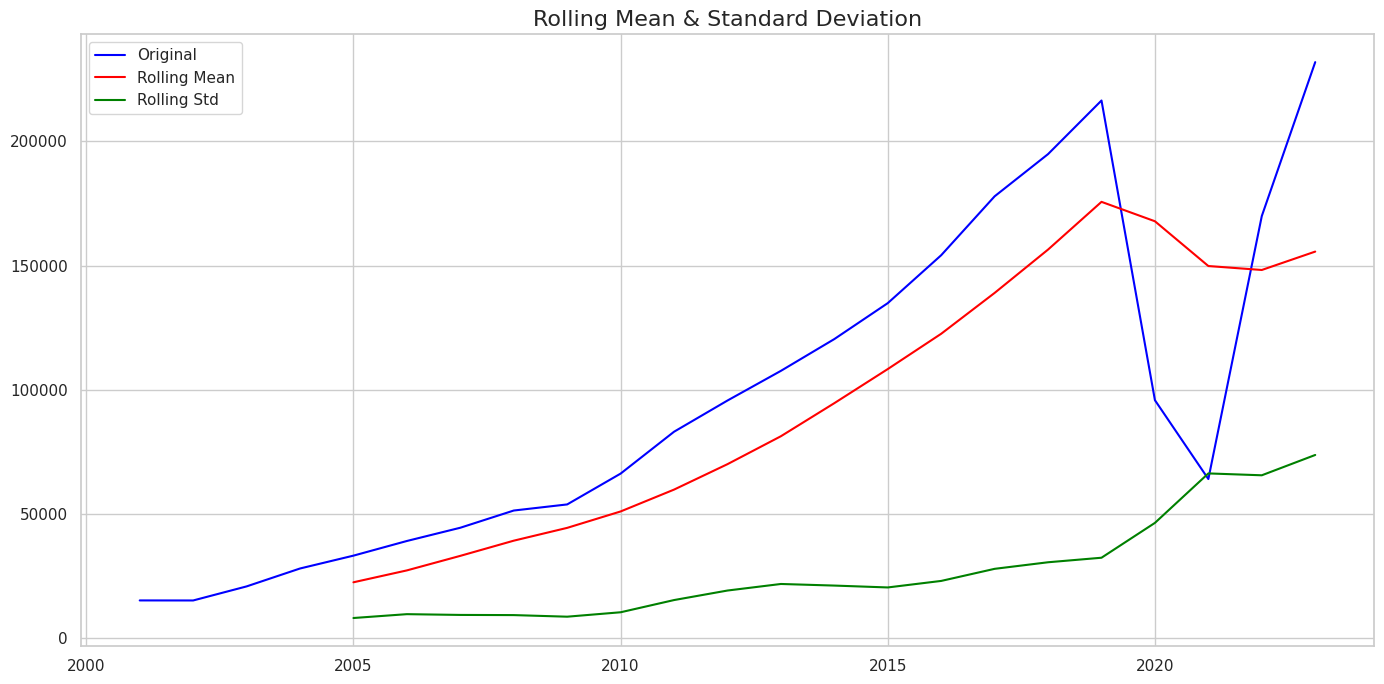

Results of Dickey-Fuller Test:
Test Statistic                 -0.986205
p-value                         0.758262
#Lags Used                      2.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64

Conclusion: The series is non-stationary (fail to reject H0)


In [30]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=5).mean()
    rolling_std = timeseries.rolling(window=5).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # Interpret the results
    if dftest[1] <= 0.05:
        print("\nConclusion: The series is stationary (reject H0)")
    else:
        print("\nConclusion: The series is non-stationary (fail to reject H0)")

# Test stationarity on the original series
test_stationarity(df_ts['FEE_Rupee_Crore'])

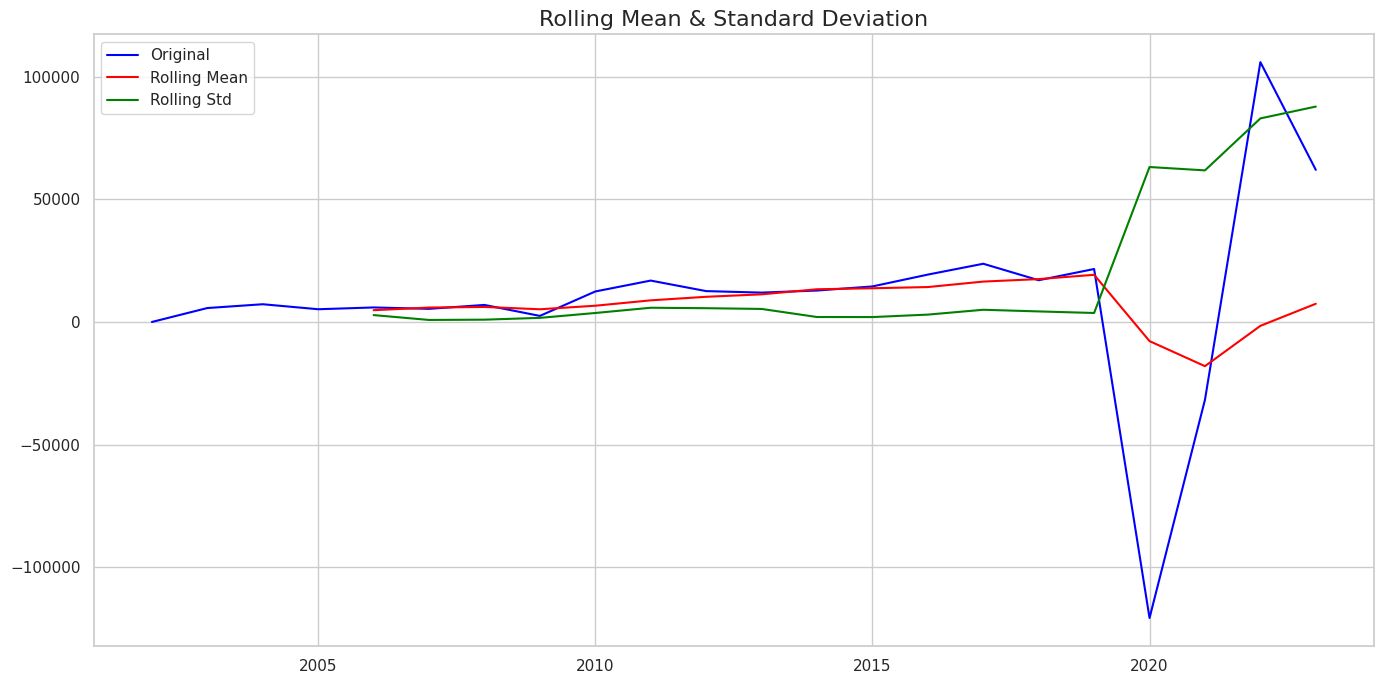

Results of Dickey-Fuller Test:
Test Statistic                 -1.684394
p-value                         0.439171
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

Conclusion: The series is non-stationary (fail to reject H0)


In [31]:
# If the series is non-stationary, let's try differencing
df_ts['FEE_diff'] = df_ts['FEE_Rupee_Crore'].diff()

# Test stationarity on the differenced series
test_stationarity(df_ts['FEE_diff'].iloc[1:])  # Skip the first NaN value

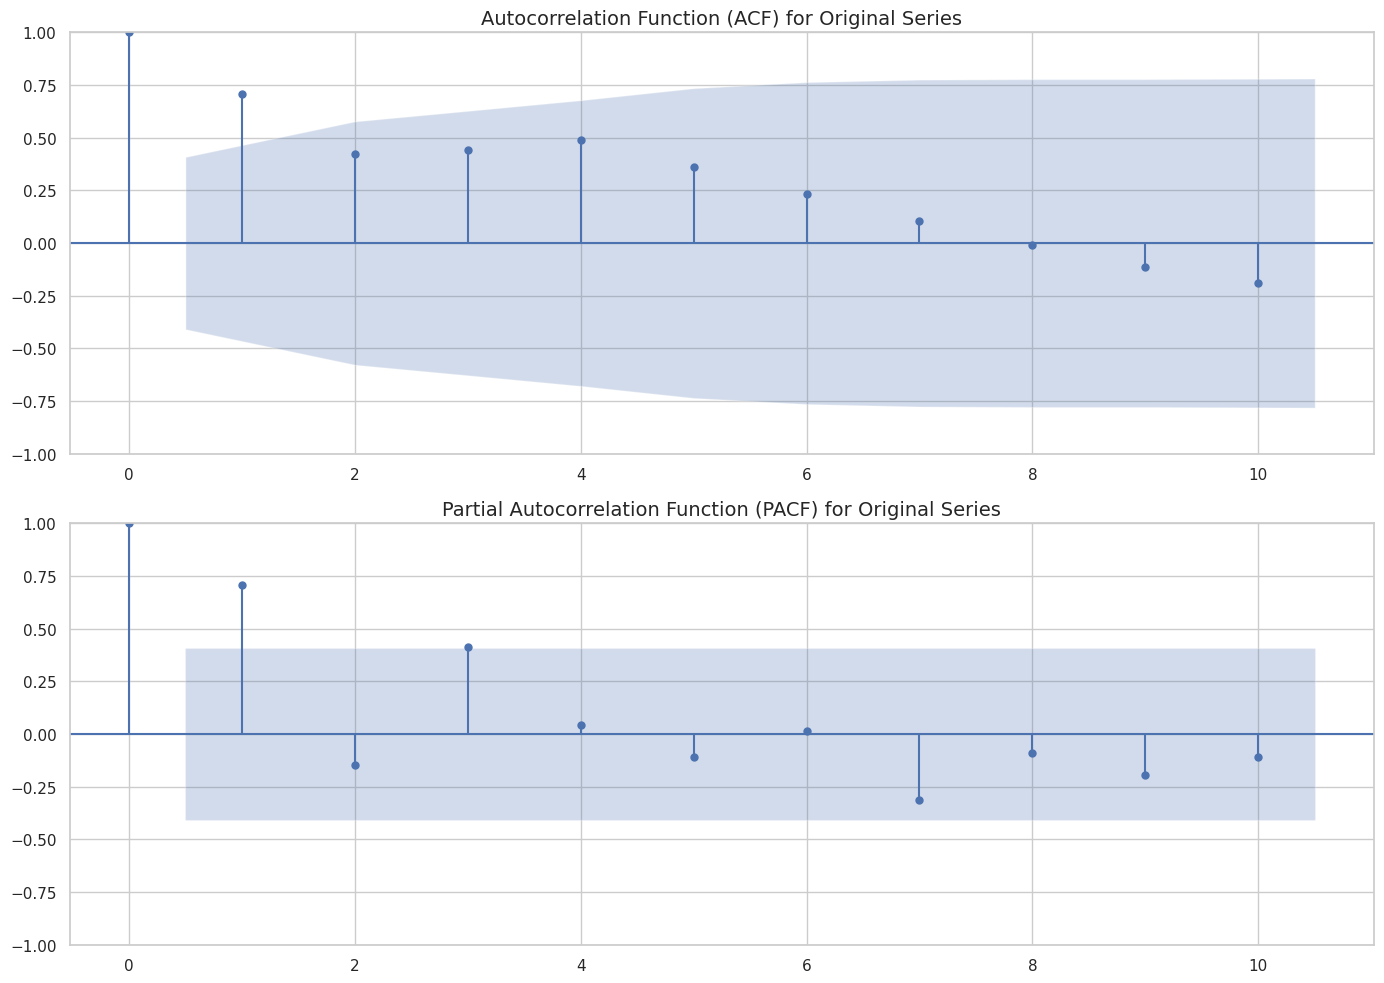

In [32]:
# Calculate ACF and PACF for the original series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
sm.graphics.tsa.plot_acf(df_ts['FEE_Rupee_Crore'].dropna(), lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Original Series', fontsize=14)

# Plot PACF
sm.graphics.tsa.plot_pacf(df_ts['FEE_Rupee_Crore'].dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for Original Series', fontsize=14)

plt.tight_layout()
plt.show()

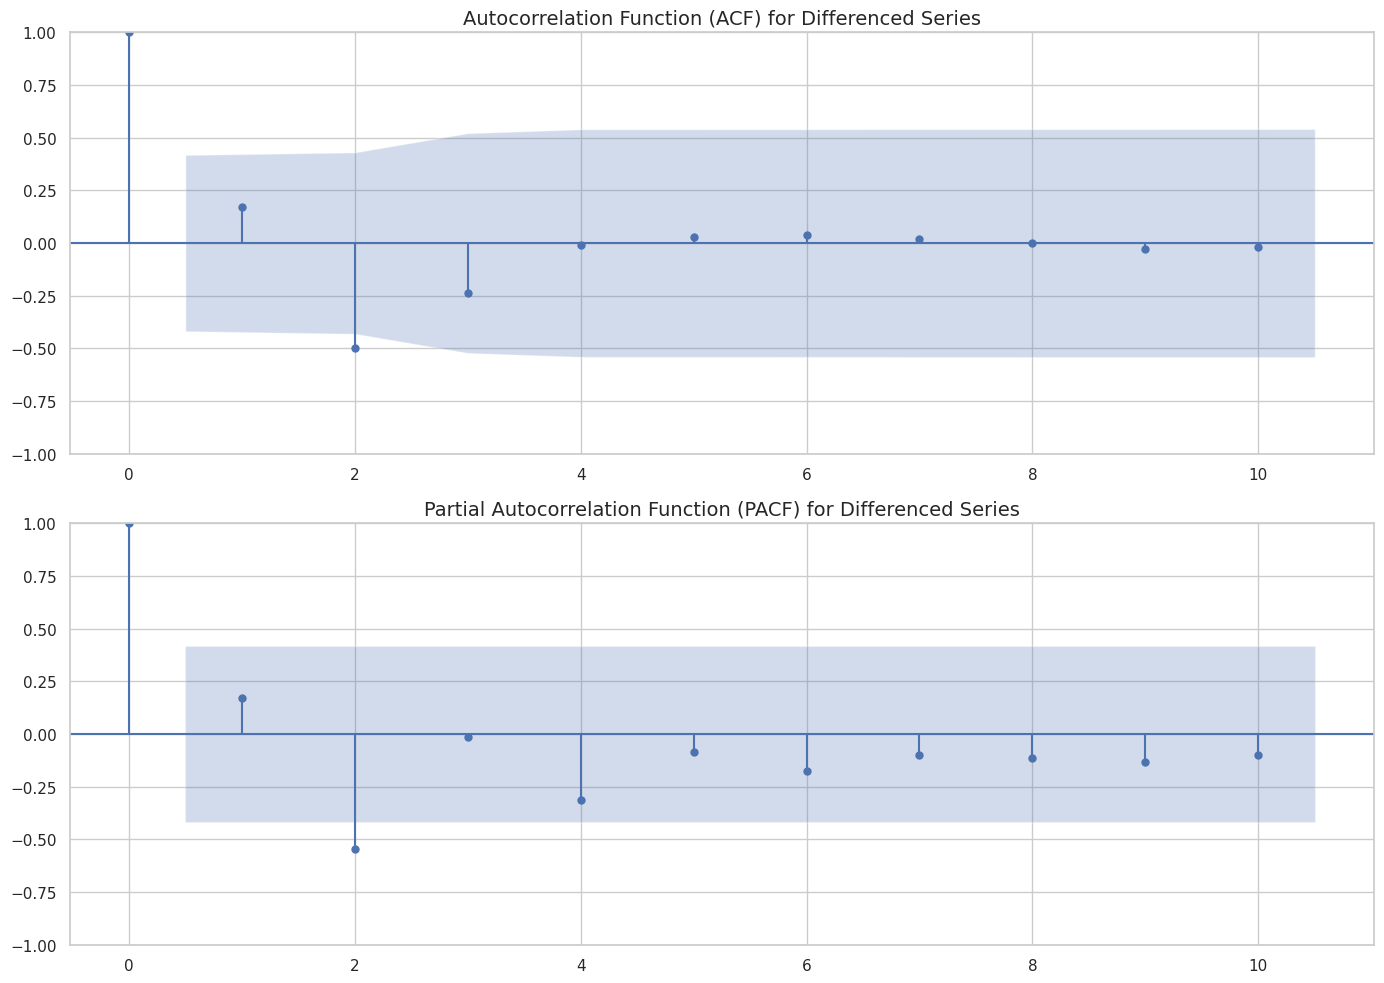

In [33]:
# Calculate ACF and PACF for the differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
sm.graphics.tsa.plot_acf(df_ts['FEE_diff'].dropna(), lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Differenced Series', fontsize=14)

# Plot PACF
sm.graphics.tsa.plot_pacf(df_ts['FEE_diff'].dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for Differenced Series', fontsize=14)

plt.tight_layout()
plt.show()

In [34]:
# Define a function to evaluate ARIMA models
def evaluate_arima_model(p, d, q):
    # Prepare train and test datasets
    train_size = int(len(df_ts) * 0.8)
    train, test = df_ts['FEE_Rupee_Crore'][:train_size], df_ts['FEE_Rupee_Crore'][train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    
    # Calculate error
    rmse = sqrt(mean_squared_error(test, forecast))
    
    return rmse, model_fit

# Try different ARIMA models
models = [
    (1, 1, 0),  # ARIMA(1,1,0) - AR(1) with first differencing
    (0, 1, 1),  # ARIMA(0,1,1) - MA(1) with first differencing
    (1, 1, 1),  # ARIMA(1,1,1) - ARMA(1,1) with first differencing
    (2, 1, 0),  # ARIMA(2,1,0) - AR(2) with first differencing
    (0, 1, 2),  # ARIMA(0,1,2) - MA(2) with first differencing
    (2, 1, 2),  # ARIMA(2,1,2) - ARMA(2,2) with first differencing
]

results = []
for order in models:
    try:
        rmse, model = evaluate_arima_model(order[0], order[1], order[2])
        results.append({'order': order, 'rmse': rmse, 'model': model})
        print(f'ARIMA{order} - RMSE: {rmse:.2f}')
    except Exception as e:
        print(f'Error with ARIMA{order}: {e}')

# Find the best model (lowest RMSE)
best_model = min(results, key=lambda x: x['rmse'])
print(f"\nBest model: ARIMA{best_model['order']} with RMSE: {best_model['rmse']:.2f}")

/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-en

ARIMA(1, 1, 0) - RMSE: 103511.70
ARIMA(0, 1, 1) - RMSE: 79842.34
ARIMA(1, 1, 1) - RMSE: 111946.76
ARIMA(2, 1, 0) - RMSE: 110676.70
ARIMA(0, 1, 2) - RMSE: 80982.34
ARIMA(2, 1, 2) - RMSE: 108739.20

Best model: ARIMA(0, 1, 1) with RMSE: 79842.34


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.p

In [35]:
# Use the best model for forecasting
best_order = best_model['order']

# Fit the best model on the entire dataset
final_model = ARIMA(df_ts['FEE_Rupee_Crore'], order=best_order)
final_model_fit = final_model.fit()

# Summary of the model
print(final_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        FEE_Rupee_Crore   No. Observations:                   23
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -262.186
Date:                Sun, 04 May 2025   AIC                            528.373
Time:                        01:13:15   BIC                            530.555
Sample:                             0   HQIC                           528.887
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6379      0.138      4.629      0.000       0.368       0.908
sigma2       1.78e+09   3.76e-13   4.74e+21      0.000    1.78e+09    1.78e+09
Ljung-Box (L1) (Q):                   0.60   Jarque-

/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


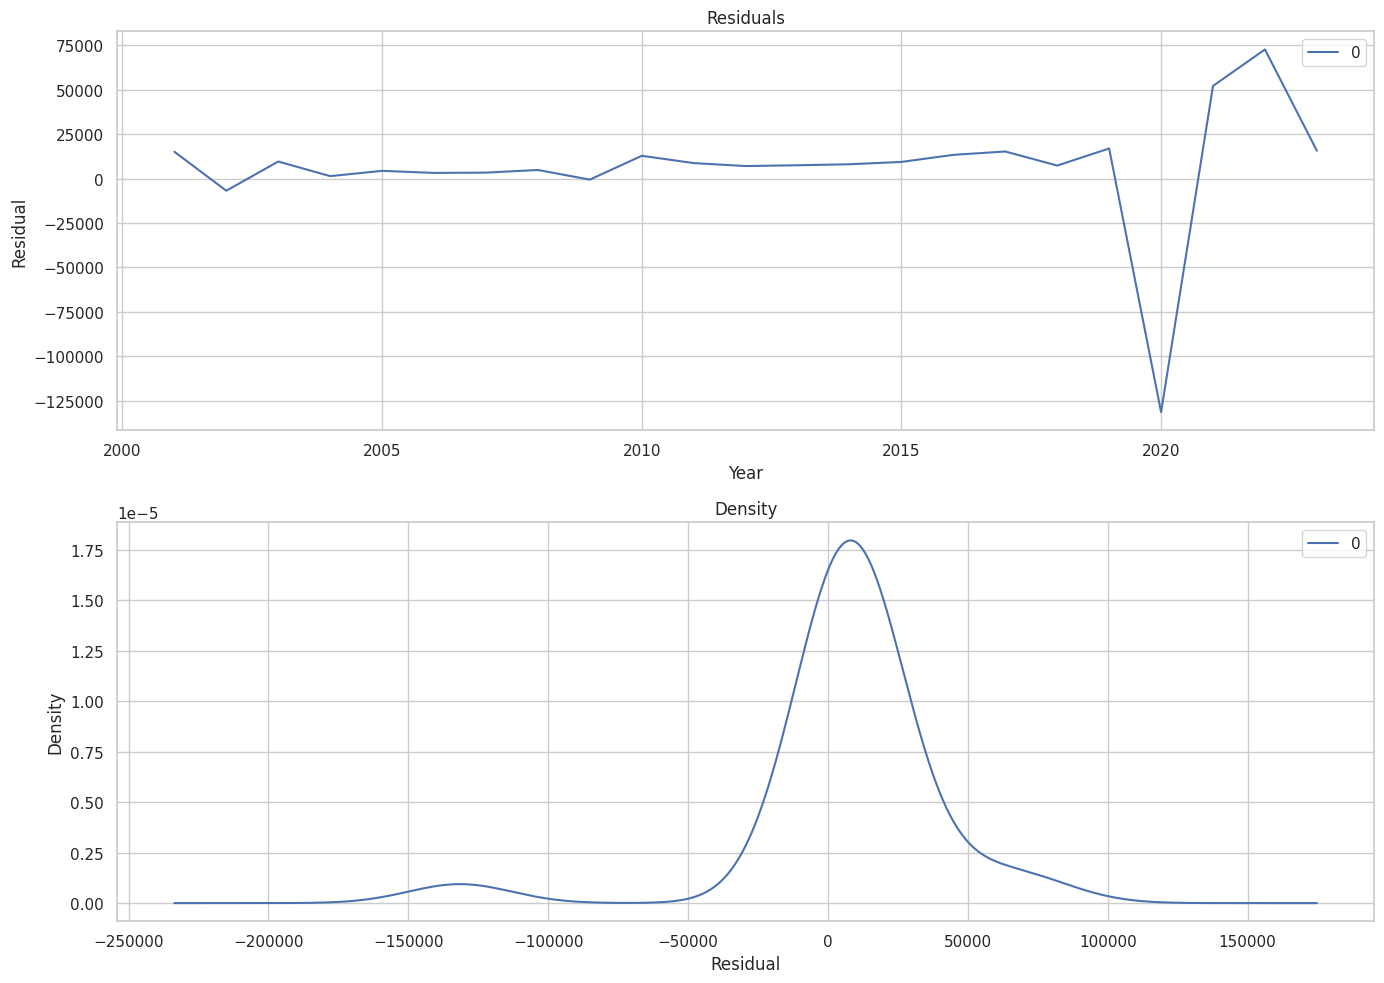

Ljung-Box Test for Residuals:
     lb_stat  lb_pvalue
10  3.45713   0.968534


In [36]:
# Plot the residuals to check if they look like white noise
residuals = pd.DataFrame(final_model_fit.resid)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot residuals
residuals.plot(title="Residuals", ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Residual')

# Plot residuals distribution
residuals.plot(kind='kde', title='Density', ax=ax2)
ax2.set_xlabel('Residual')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test for Residuals:\n", lb_test)

In [37]:
# Create a function to test multiple ARIMA configurations
def evaluate_arima_configs(data, p_values, d_values, q_values, train_test_split=0.8):
    train_size = int(len(data) * train_test_split)
    train, test = data[:train_size], data[train_size:]
    
    best_score = float("inf")
    best_order = None
    best_model = None
    results = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    
                    # Forecast
                    forecast = model_fit.forecast(steps=len(test))
                    
                    # Calculate metrics
                    mse = mean_squared_error(test, forecast)
                    rmse = sqrt(mse)
                    mae = np.mean(np.abs(test - forecast))
                    aic = model_fit.aic
                    bic = model_fit.bic
                    
                    # Store results
                    result = {
                        'order': order,
                        'rmse': rmse,
                        'mae': mae,
                        'aic': aic,
                        'bic': bic
                    }
                    results.append(result)
                    
                    # Check if this is the best model so far
                    if rmse < best_score:
                        best_score = rmse
                        best_order = order
                        best_model = model_fit
                    
                    print(f'ARIMA{order} - RMSE: {rmse:.2f}, AIC: {aic:.2f}, BIC: {bic:.2f}')
                except Exception as e:
                    print(f'Error with ARIMA{order}: {e}')
    
    return results, best_order, best_model

# Define parameter ranges
p_values = range(0, 3)  # AR parameters
d_values = range(0, 2)  # Differencing
q_values = range(0, 3)  # MA parameters

# Evaluate models
results, best_order, best_model = evaluate_arima_configs(
    df_ts['FEE_Rupee_Crore'], p_values, d_values, q_values
)

# Display the best model
print(f"\nBest ARIMA model: {best_order}")

# Create a DataFrame with all results
results_df = pd.DataFrame(results)
results_df['order_str'] = results_df['order'].apply(lambda x: f"ARIMA{x}")
results_df.set_index('order_str', inplace=True)
results_df.drop('order', axis=1, inplace=True)

# Sort by RMSE
results_df = results_df.sort_values('rmse')

# Display top 5 models by RMSE
print("\nTop 5 ARIMA models by RMSE:")
results_df.head(5)

ARIMA(0, 0, 0) - RMSE: 100509.18, AIC: 483.37, BIC: 485.15
ARIMA(0, 0, 1) - RMSE: 87379.84, AIC: 436.37, BIC: 439.04
ARIMA(0, 0, 2) - RMSE: 83741.51, AIC: 437.84, BIC: 441.40
ARIMA(0, 1, 0) - RMSE: 76715.70, AIC: 370.43, BIC: 371.26
ARIMA(0, 1, 1) - RMSE: 79842.34, AIC: 355.91, BIC: 357.58
ARIMA(0, 1, 2) - RMSE: 80982.34, AIC: 368.04, BIC: 370.54
ARIMA(1, 0, 0) - RMSE: 75515.27, AIC: 400.09, BIC: 402.76


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-en

ARIMA(1, 0, 1) - RMSE: 78730.68, AIC: 385.23, BIC: 388.79
ARIMA(1, 0, 2) - RMSE: 79495.08, AIC: 379.22, BIC: 383.67
ARIMA(1, 1, 0) - RMSE: 103511.70, AIC: 344.32, BIC: 345.99


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.p

ARIMA(1, 1, 1) - RMSE: 111946.76, AIC: 344.29, BIC: 346.79
ARIMA(1, 1, 2) - RMSE: 102354.86, AIC: 346.32, BIC: 349.65
ARIMA(2, 0, 0) - RMSE: 96270.56, AIC: 367.13, BIC: 370.69
ARIMA(2, 0, 1) - RMSE: 94600.37, AIC: 369.13, BIC: 373.58


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.p

ARIMA(2, 0, 2) - RMSE: 96698.98, AIC: 369.90, BIC: 375.24
ARIMA(2, 1, 0) - RMSE: 110676.70, AIC: 345.31, BIC: 347.81
ARIMA(2, 1, 1) - RMSE: 111045.85, AIC: 346.26, BIC: 349.60
ARIMA(2, 1, 2) - RMSE: 108739.20, AIC: 346.36, BIC: 350.53

Best ARIMA model: (1, 0, 0)

Top 5 ARIMA models by RMSE:


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,rmse,mae,aic,bic
order_str,,,,
"ARIMA(1, 0, 0)",75515.266927,NaN,400.085222,402.756337
"ARIMA(0, 1, 0)",76715.699392,NaN,370.425141,371.258354
"ARIMA(1, 0, 1)",78730.677228,NaN,385.230087,388.791574
"ARIMA(1, 0, 2)",79495.081830,NaN,379.221454,383.673312
"ARIMA(0, 1, 1)",79842.335348,NaN,355.912546,357.578973


In [38]:
# Prepare train and test datasets
train_size = int(len(df_ts) * 0.8)
train_data = df_ts['FEE_Rupee_Crore'][:train_size]
test_data = df_ts['FEE_Rupee_Crore'][train_size:]

# Try other exponential smoothing variants
smoothing_models = [
    ('Simple Exponential Smoothing', ExponentialSmoothing(train_data, trend=None, seasonal=None)),
    ('Holt Linear Trend', ExponentialSmoothing(train_data, trend='add', seasonal=None)),
    ('Exponential Trend', ExponentialSmoothing(train_data, trend='mul', seasonal=None))
]

# Fit models and evaluate
smoothing_results = []

for name, model in smoothing_models:
    try:
        fitted_model = model.fit()
        
        # Forecast for test period
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calculate metrics
        rmse = sqrt(mean_squared_error(test_data, forecast))
        mae = np.mean(np.abs(test_data - forecast))
        
        # Store results
        result = {
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'AIC': fitted_model.aic if hasattr(fitted_model, 'aic') else np.nan,
            'BIC': fitted_model.bic if hasattr(fitted_model, 'bic') else np.nan
        }
        smoothing_results.append(result)
        
        print(f'{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}')
    except Exception as e:
        print(f'Error with {name}: {e}')
        
# Create DataFrame for smoothing results
smoothing_df = pd.DataFrame(smoothing_results)
smoothing_df.set_index('Model', inplace=True)

# Display exponential smoothing results
print("\nExponential Smoothing Models:")
smoothing_df

Simple Exponential Smoothing - RMSE: 76671.89, MAE: nan
Holt Linear Trend - RMSE: 115313.45, MAE: nan
Exponential Trend - RMSE: 139161.19, MAE: nan

Exponential Smoothing Models:


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-en

,RMSE,MAE,AIC,BIC
Model,,,,
Simple Exponential Smoothing,76671.894966,NaN,342.761067,344.541810
Holt Linear Trend,115313.447787,NaN,309.588430,313.149917
Exponential Trend,139161.186019,NaN,326.692568,330.254055


In [39]:
# Get the best exponential smoothing model
best_smoothing_model = smoothing_df.index[smoothing_df['RMSE'].argmin()]
print(f"Best exponential smoothing model: {best_smoothing_model}")
print(f"Best ARIMA model: ARIMA{best_order}")

# Let's compare these models by visualizing their forecasts
# First, refit the models on the entire dataset
final_arima = ARIMA(df_ts['FEE_Rupee_Crore'], order=best_order)
final_arima_fit = final_arima.fit()

# Find and fit the best smoothing model based on the name
if best_smoothing_model == 'Simple Exponential Smoothing':
    final_smoothing = ExponentialSmoothing(df_ts['FEE_Rupee_Crore'], trend=None, seasonal=None)
elif best_smoothing_model == 'Holt Linear Trend':
    final_smoothing = ExponentialSmoothing(df_ts['FEE_Rupee_Crore'], trend='add', seasonal=None)
elif best_smoothing_model == 'Exponential Trend':
    final_smoothing = ExponentialSmoothing(df_ts['FEE_Rupee_Crore'], trend='mul', seasonal=None)
else:
    final_smoothing = ExponentialSmoothing(df_ts['FEE_Rupee_Crore'], trend='add', seasonal=None)  # Default to Holt

final_smoothing_fit = final_smoothing.fit()

# Generate forecasts for the next 5 years
forecast_years = list(range(df_ts.index[-1] + 1, df_ts.index[-1] + 6))
arima_forecast = final_arima_fit.forecast(steps=5)
smoothing_forecast = final_smoothing_fit.forecast(steps=5)

# Create DataFrame for forecasts
compare_df = pd.DataFrame({
    'Year': forecast_years,
    f'ARIMA{best_order}': arima_forecast,
    best_smoothing_model: smoothing_forecast
})
compare_df.set_index('Year', inplace=True)

# Calculate the optimal weights for a weighted ensemble
# We'll use the inverse of the RMSE as weights
arima_weight = 1 / results_df.iloc[0]['rmse']
smoothing_weight = 1 / smoothing_df.iloc[0]['RMSE']
total_weight = arima_weight + smoothing_weight

arima_norm_weight = arima_weight / total_weight
smoothing_norm_weight = smoothing_weight / total_weight

print(f"Optimal weights: ARIMA: {arima_norm_weight:.2f}, {best_smoothing_model}: {smoothing_norm_weight:.2f}")

# Calculate weighted ensemble forecast
compare_df['Weighted Ensemble'] = (arima_norm_weight * compare_df[f'ARIMA{best_order}']) + \
                               (smoothing_norm_weight * compare_df[best_smoothing_model])

# Display the forecasts
print("\nForecasts from best models and weighted ensemble:")
compare_df

Best exponential smoothing model: Simple Exponential Smoothing
Best ARIMA model: ARIMA(1, 0, 0)
Optimal weights: ARIMA: 0.50, Simple Exponential Smoothing: 0.50

Forecasts from best models and weighted ensemble:


/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/himanshu-skid19/miniconda3/envs/faiss-en

,"ARIMA(1, 0, 0)",Simple Exponential Smoothing,Weighted Ensemble
Year,,,
2024,214427.116685,231614.30557,222955.399493
2025,199183.784083,231614.30557,215275.808248
2026,185906.027620,231614.30557,208586.474297
2027,174340.392907,231614.30557,202759.707315
2028,164266.107638,231614.30557,197684.282211


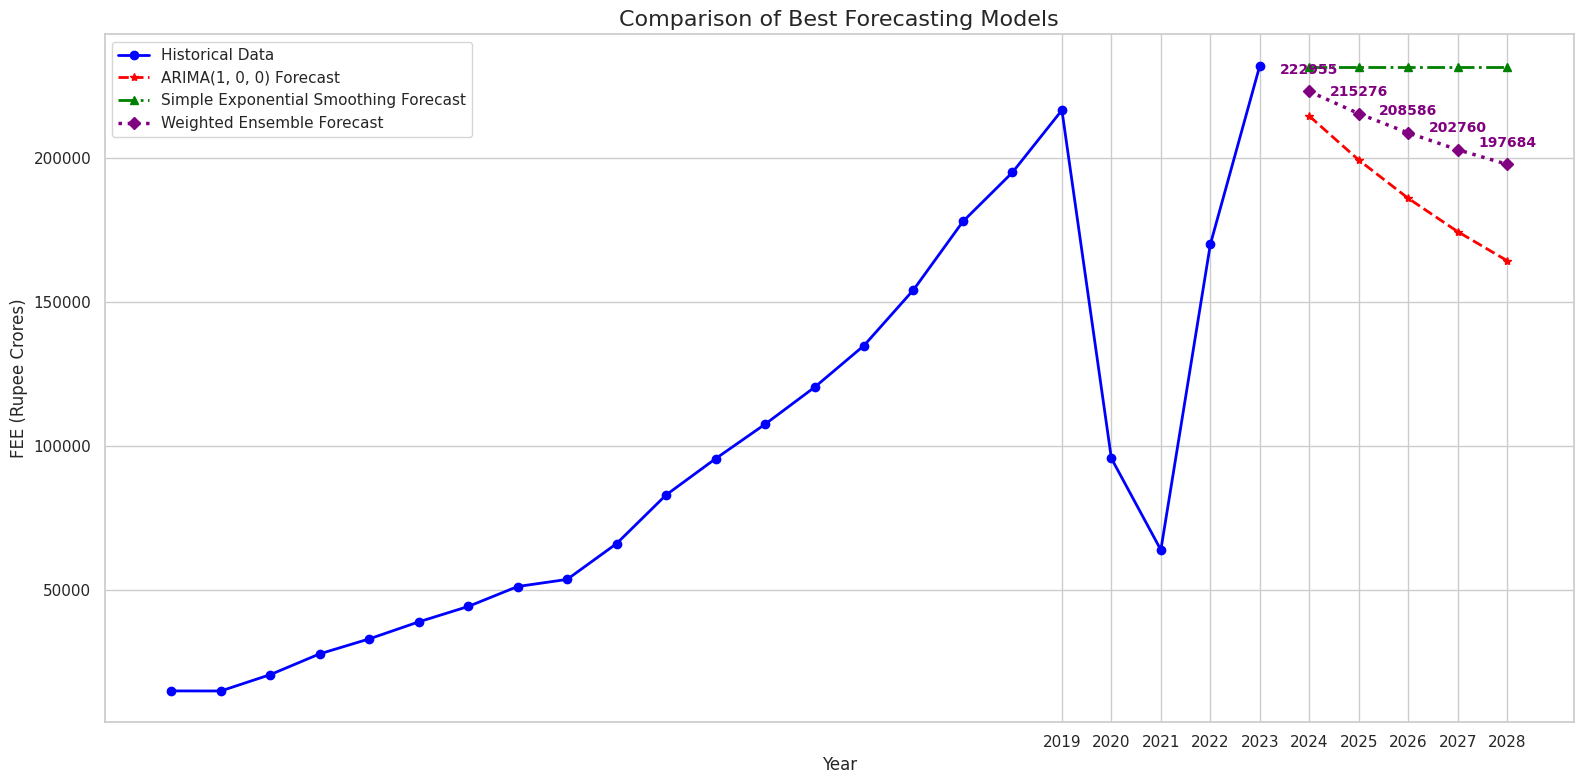

In [40]:
# Visualize the forecasts
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', linestyle='-', 
         color='blue', label='Historical Data', linewidth=2)

# Plot ARIMA forecast
plt.plot(compare_df.index, compare_df[f'ARIMA{best_order}'], marker='*', 
         linestyle='--', color='red', label=f'ARIMA{best_order} Forecast', linewidth=2)

# Plot Exponential Smoothing forecast
plt.plot(compare_df.index, compare_df[best_smoothing_model], marker='^', 
         linestyle='-.', color='green', label=f'{best_smoothing_model} Forecast', linewidth=2)

# Plot Weighted Ensemble forecast
plt.plot(compare_df.index, compare_df['Weighted Ensemble'], marker='D', 
         linestyle=':', color='purple', label='Weighted Ensemble Forecast', linewidth=2.5)

# Add value labels for the weighted ensemble forecast
for i, v in enumerate(compare_df['Weighted Ensemble']):
    plt.text(compare_df.index[i], v + 5000, f'{v:.0f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='purple')

plt.title('Comparison of Best Forecasting Models', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')

# Set x-axis ticks
plt.xticks(list(df_ts.index[-5:]) + list(compare_df.index))  # Last 5 historical years + forecast

plt.tight_layout()
plt.show()

### new nb

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from math import sqrt, log, exp
import warnings


In [42]:

# Suppress warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_csv('./Data/yearwise_FEE_Rupee.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check the data types and basic info
print("\nDataset info:")
df.info()

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Basic statistics
print("\nSummary statistics:")
print(df.describe())

First 5 rows of the dataset:
   Year  FEE_Rupee_Crore  PercentChangeoverPreviousYear
0  2001            15083                           -3.5
1  2002            15064                           -0.1
2  2003            20729                           37.6
3  2004            27944                           34.8
4  2005            33123                           18.5

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           23 non-null     int64  
 1   FEE_Rupee_Crore                23 non-null     int64  
 2   PercentChangeoverPreviousYear  23 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 684.0 bytes

Missing values count:
Year                             0
FEE_Rupee_Crore                  0
PercentChangeoverPreviousYear    0
dtype: int64

Summary statistics:
 

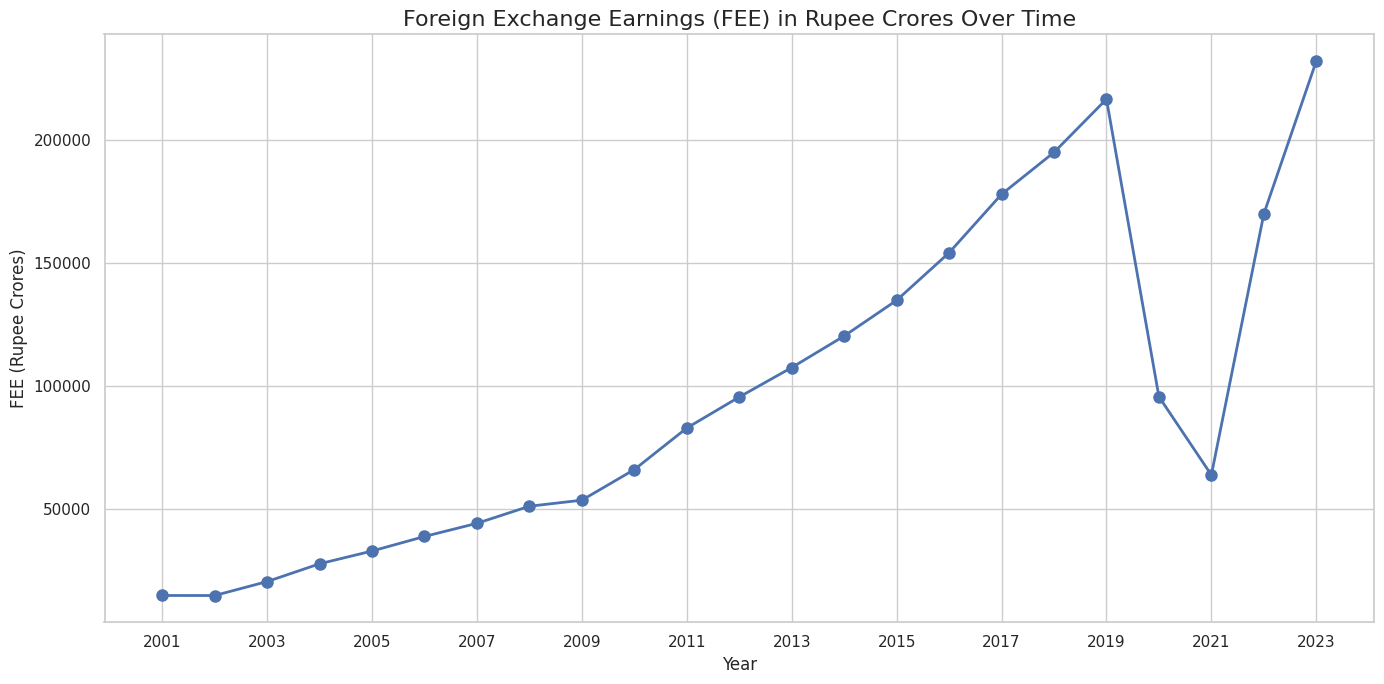

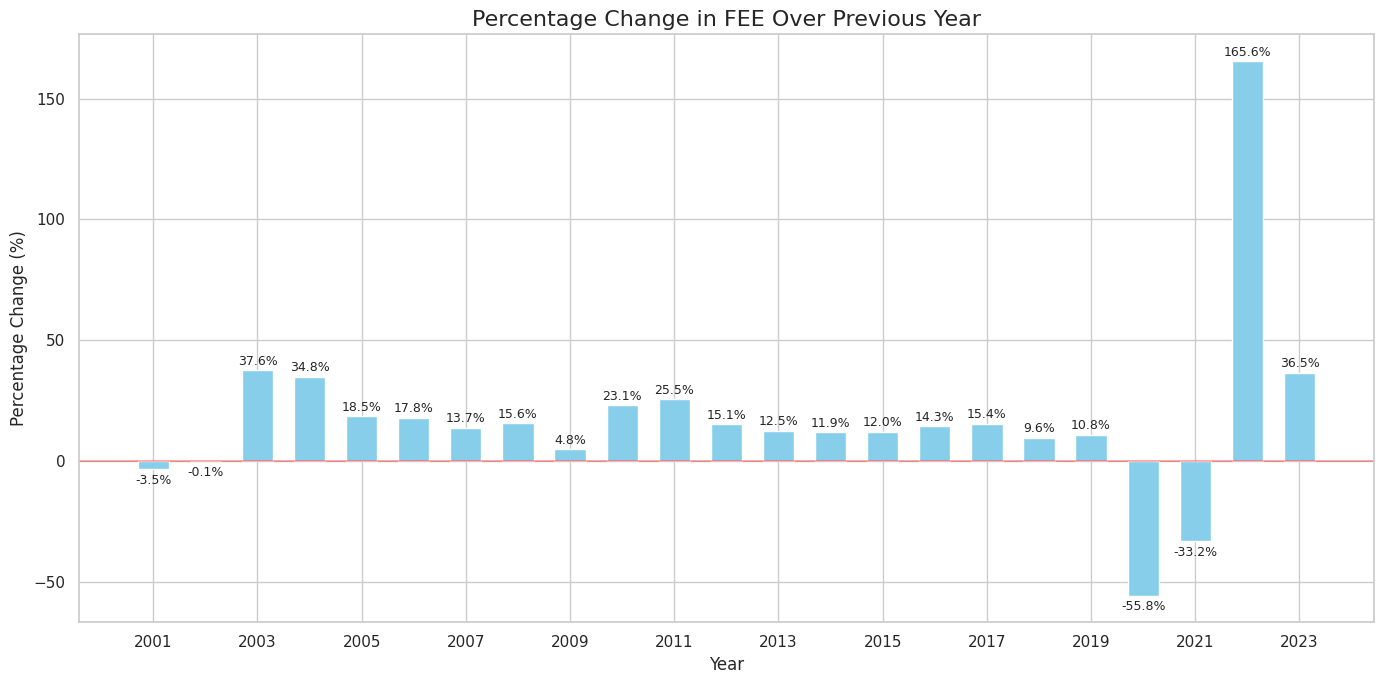

In [44]:
#Set Year as the index for time series analysis
df_ts = df.copy()
df_ts.set_index('Year', inplace=True)

# Plot the FEE values over time
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Foreign Exchange Earnings (FEE) in Rupee Crores Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.grid(True)
plt.xticks(df_ts.index[::2])  # Show every other year for clarity
plt.tight_layout()
plt.show()

# Plot the percentage change over previous year
plt.figure(figsize=(14, 7))
plt.bar(df_ts.index, df_ts['PercentChangeoverPreviousYear'], color='skyblue', width=0.6)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
plt.title('Percentage Change in FEE Over Previous Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.grid(True, axis='y')
plt.xticks(df_ts.index[::2])  # Show every other year for clarity
for i, v in enumerate(df_ts['PercentChangeoverPreviousYear']):
    if not np.isnan(v):  # Skip NaN values
        plt.text(df_ts.index[i], v + (1 if v > 0 else -2), f'{v:.1f}%', 
                 ha='center', va='bottom' if v > 0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()


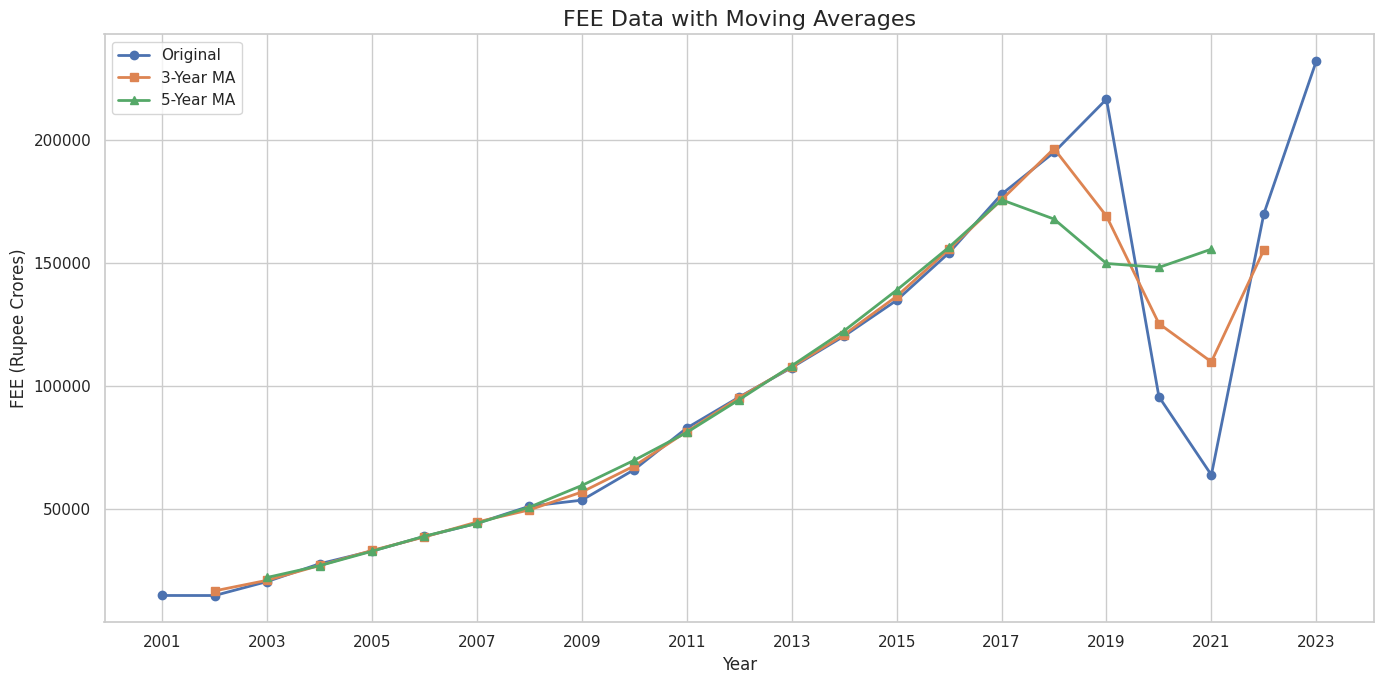

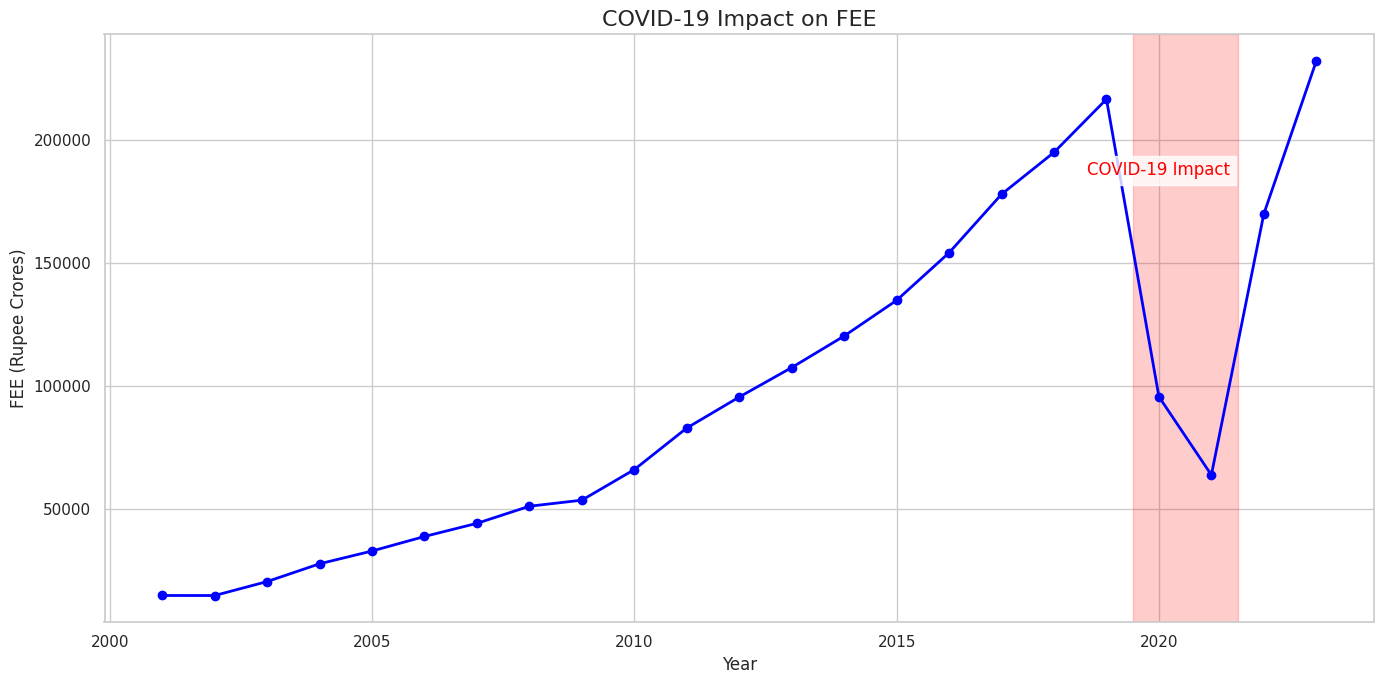

In [45]:
# Apply moving average to isolate the trend
df_ts['MA_3'] = df_ts['FEE_Rupee_Crore'].rolling(window=3, center=True).mean()
df_ts['MA_5'] = df_ts['FEE_Rupee_Crore'].rolling(window=5, center=True).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', label='Original', linewidth=2)
plt.plot(df_ts.index, df_ts['MA_3'], marker='s', label='3-Year MA', linewidth=2)
plt.plot(df_ts.index, df_ts['MA_5'], marker='^', label='5-Year MA', linewidth=2)
plt.title('FEE Data with Moving Averages', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(df_ts.index[::2])
plt.tight_layout()
plt.show()

# Highlighting the COVID-19 Impact
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', linestyle='-', linewidth=2, color='blue')
plt.axvspan(2019.5, 2021.5, alpha=0.2, color='red')
plt.text(2020, df_ts['FEE_Rupee_Crore'].max()*0.8, 'COVID-19 Impact', 
         fontsize=12, color='red', ha='center', bbox=dict(facecolor='white', alpha=0.8))
plt.title('COVID-19 Impact on FEE', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:

# Define time periods for analysis
# Assuming the data spans multiple decades, we'll divide it into periods
min_year = df_ts.index.min()
max_year = df_ts.index.max()

# Create time periods (adjust based on actual data span)
period_ranges = []
current_start = min_year
period_length = 5  # 5-year periods

while current_start <= max_year:
    period_end = min(current_start + period_length - 1, max_year)
    period_ranges.append((current_start, period_end))
    current_start = period_end + 1

# Calculate statistics for each period
period_stats = []

for start_year, end_year in period_ranges:
    period_data = df_ts.loc[start_year:end_year, 'FEE_Rupee_Crore']
    period_growth = df_ts.loc[start_year:end_year, 'PercentChangeoverPreviousYear'].dropna()
    
    stats = {
        'Period': f"{start_year}-{end_year}",
        'Average FEE (Crore)': period_data.mean(),
        'CAGR (%)': ((period_data.iloc[-1] / period_data.iloc[0]) ** (1 / (end_year - start_year)) - 1) * 100 if len(period_data) > 1 else np.nan,
        'Avg Annual Growth (%)': period_growth.mean() if len(period_growth) > 0 else np.nan,
        'Volatility (%)': period_growth.std() if len(period_growth) > 1 else np.nan,
        'Min FEE (Crore)': period_data.min(),
        'Max FEE (Crore)': period_data.max(),
        'Range (Crore)': period_data.max() - period_data.min(),
    }
    period_stats.append(stats)

# Create a summary DataFrame
summary_periods_df = pd.DataFrame(period_stats)
summary_periods_df.set_index('Period', inplace=True)

# Display the summary statistics by period
print("FEE Summary Statistics by Period:")
print(summary_periods_df.round(2))



FEE Summary Statistics by Period:
           Average FEE (Crore)  CAGR (%)  Avg Annual Growth (%)  \
Period                                                            
2001-2005              22388.6     21.73                  17.46   
2006-2010              50921.4     14.11                  15.00   
2011-2015             108283.4     12.89                  15.40   
2016-2020             167821.2    -11.23                  -1.14   
2021-2023             155274.0     90.40                  56.30   

           Volatility (%)  Min FEE (Crore)  Max FEE (Crore)  Range (Crore)  
Period                                                                      
2001-2005           19.07            15064            33123          18059  
2006-2010            6.70            39025            66172          27147  
2011-2015            5.79            83036           134844          51808  
2016-2020           30.65            95738           216467         120729  
2021-2023          100.87         


Testing stationarity on original series:


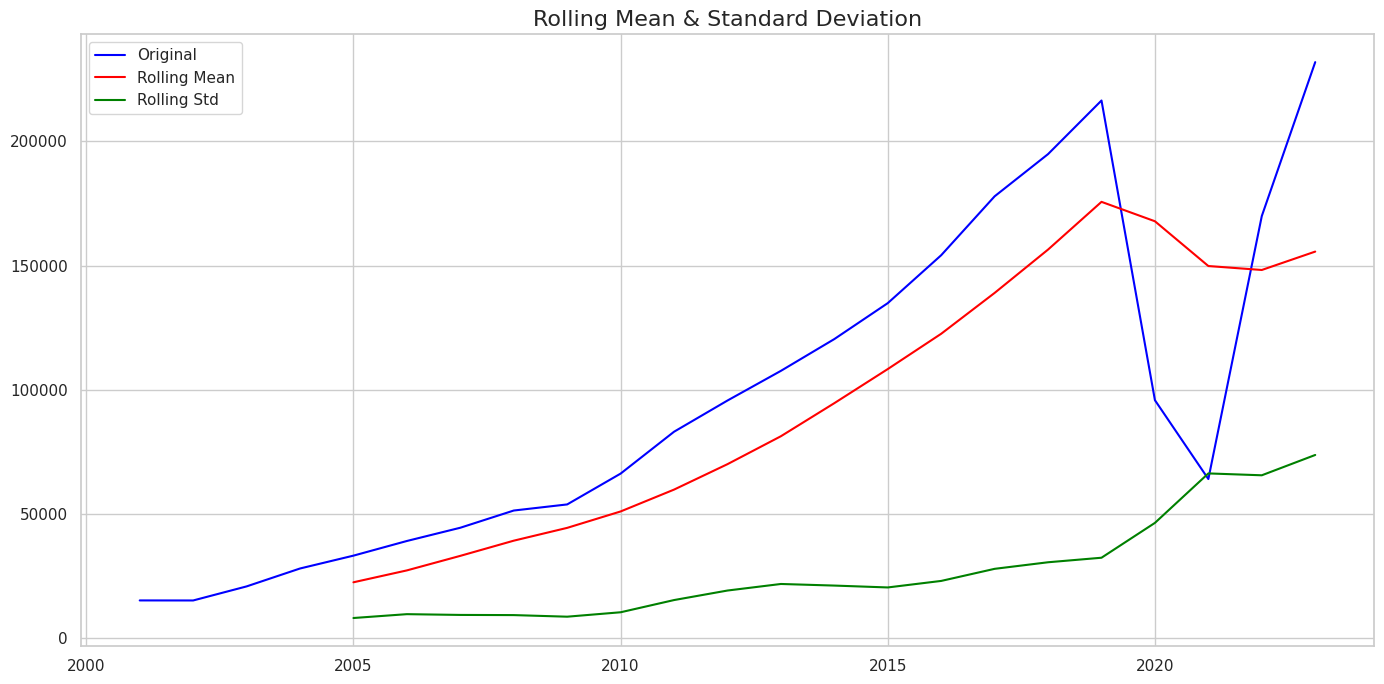

Results of Dickey-Fuller Test:
Test Statistic                 -0.986205
p-value                         0.758262
#Lags Used                      2.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64

Conclusion: The series is non-stationary (fail to reject H0)


In [47]:

# Test stationarity on the original series
def test_stationarity(timeseries):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=5).mean()
    rolling_std = timeseries.rolling(window=5).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # Interpret the results
    if dftest[1] <= 0.05:
        print("\nConclusion: The series is stationary (reject H0)")
    else:
        print("\nConclusion: The series is non-stationary (fail to reject H0)")

print("\nTesting stationarity on original series:")
test_stationarity(df_ts['FEE_Rupee_Crore'])


Testing stationarity on differenced series:


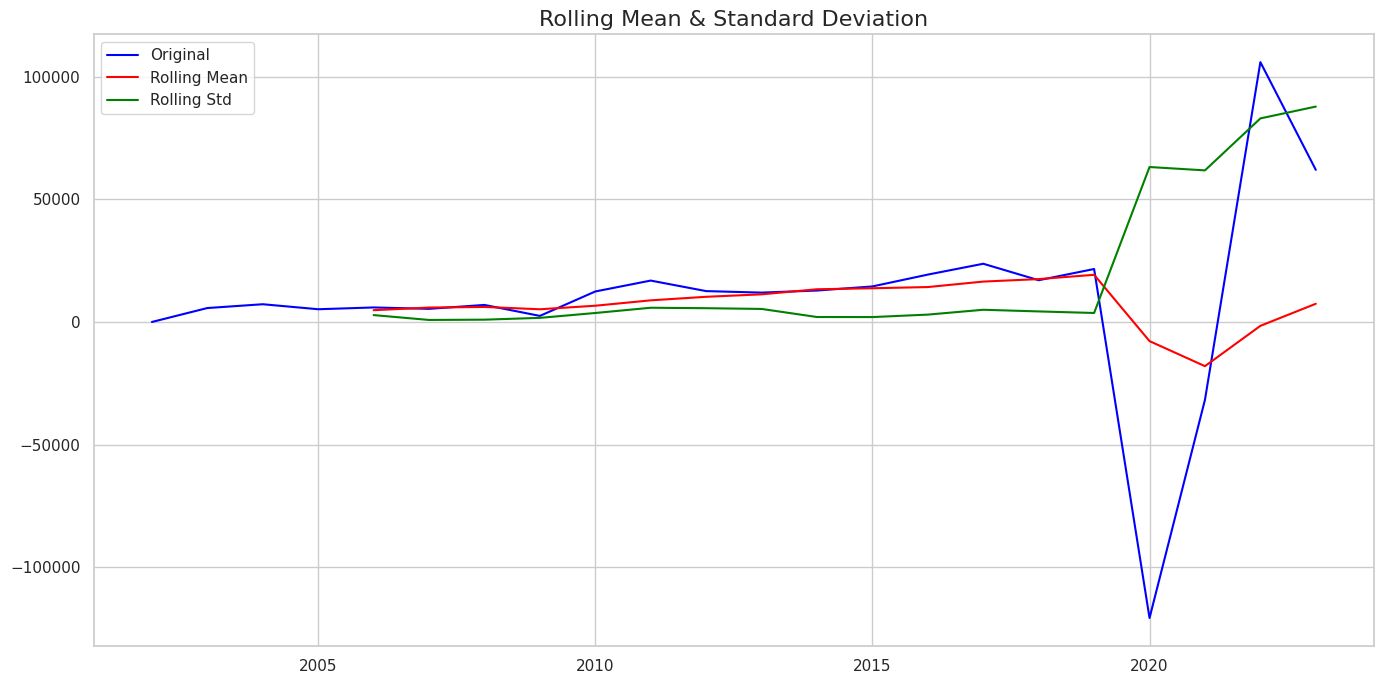

Results of Dickey-Fuller Test:
Test Statistic                 -1.684394
p-value                         0.439171
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

Conclusion: The series is non-stationary (fail to reject H0)


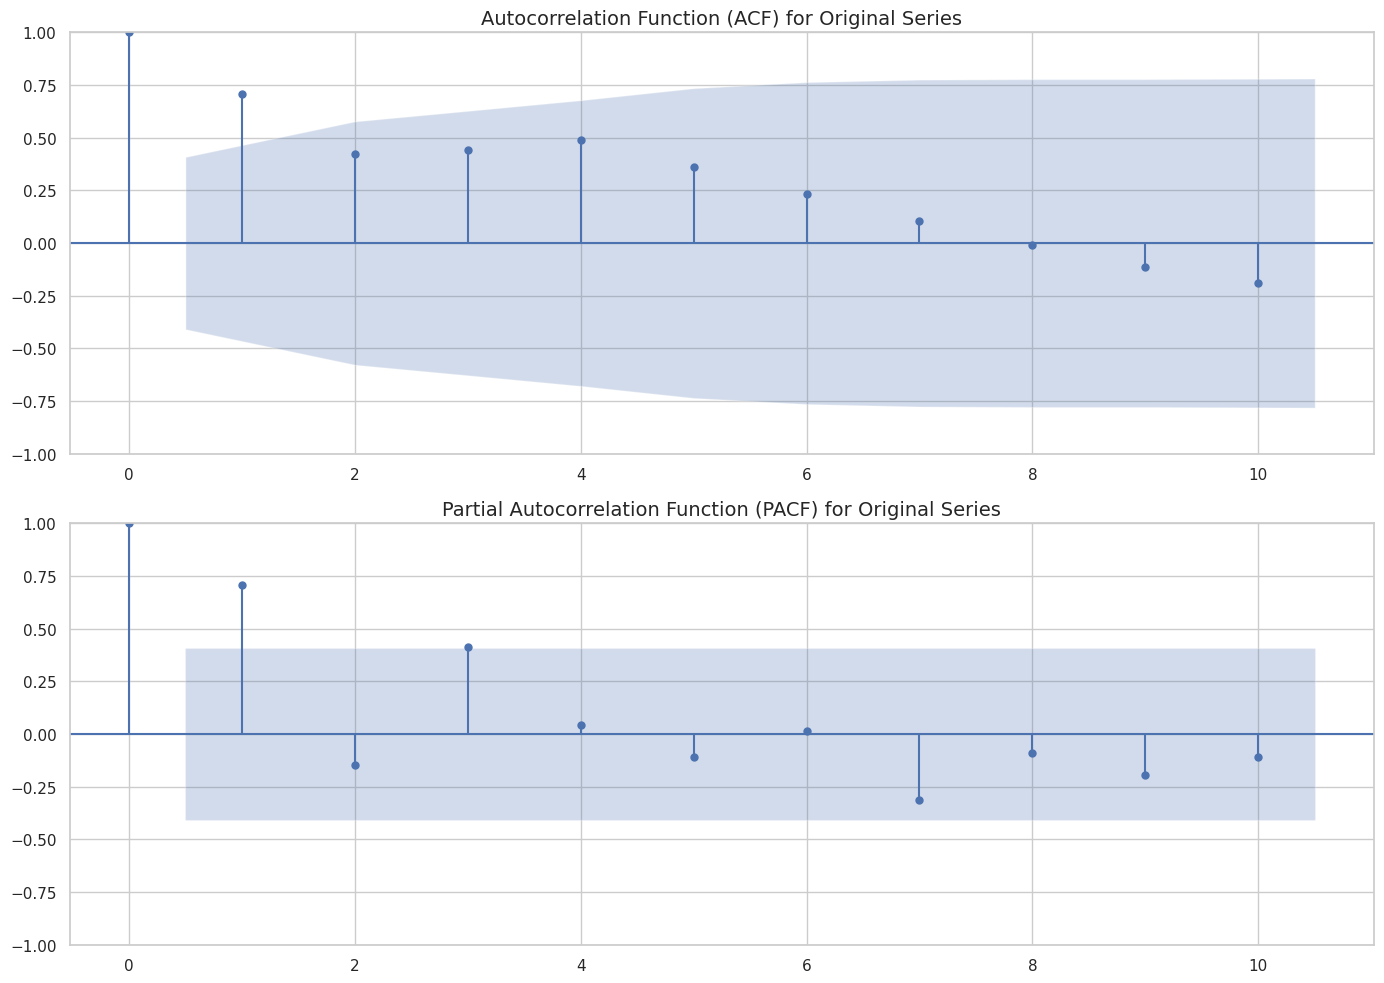

In [48]:

# If the series is non-stationary, try differencing
df_ts['FEE_diff'] = df_ts['FEE_Rupee_Crore'].diff()

print("\nTesting stationarity on differenced series:")
test_stationarity(df_ts['FEE_diff'].iloc[1:])  # Skip the first NaN value

# Calculate ACF and PACF for the original series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
sm.graphics.tsa.plot_acf(df_ts['FEE_Rupee_Crore'].dropna(), lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Original Series', fontsize=14)

# Plot PACF
sm.graphics.tsa.plot_pacf(df_ts['FEE_Rupee_Crore'].dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for Original Series', fontsize=14)

plt.tight_layout()
plt.show()


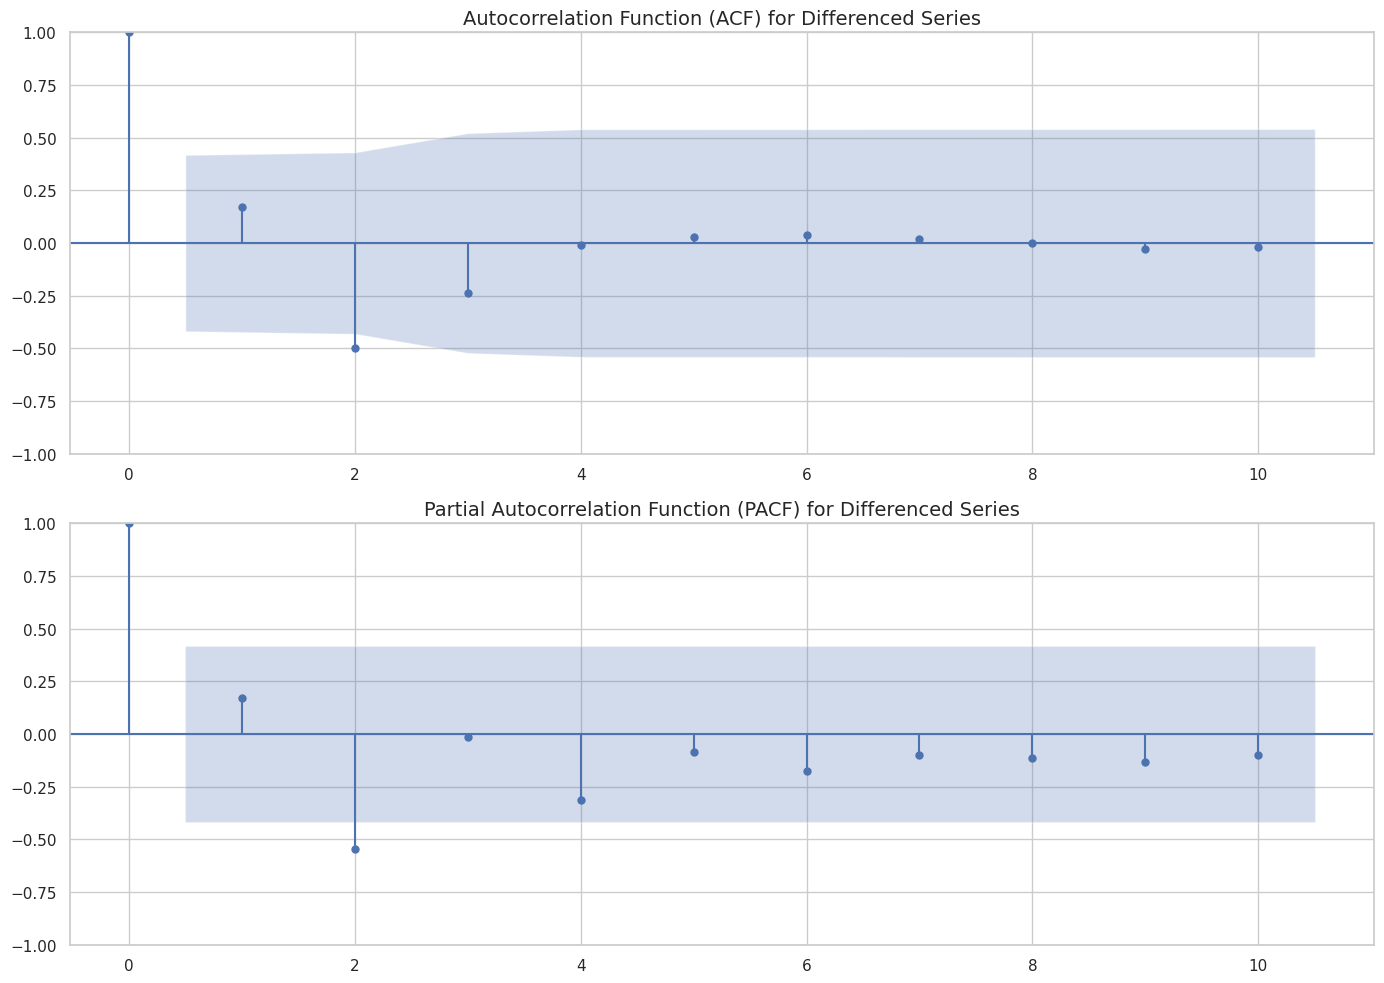

In [49]:

# Calculate ACF and PACF for the differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
sm.graphics.tsa.plot_acf(df_ts['FEE_diff'].dropna(), lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Differenced Series', fontsize=14)

# Plot PACF
sm.graphics.tsa.plot_pacf(df_ts['FEE_diff'].dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for Differenced Series', fontsize=14)

plt.tight_layout()
plt.show()


Adjusted 2020 FEE value from 95738 to 129880.2
Adjusted 2021 FEE value from 63978 to 183996.94999999998


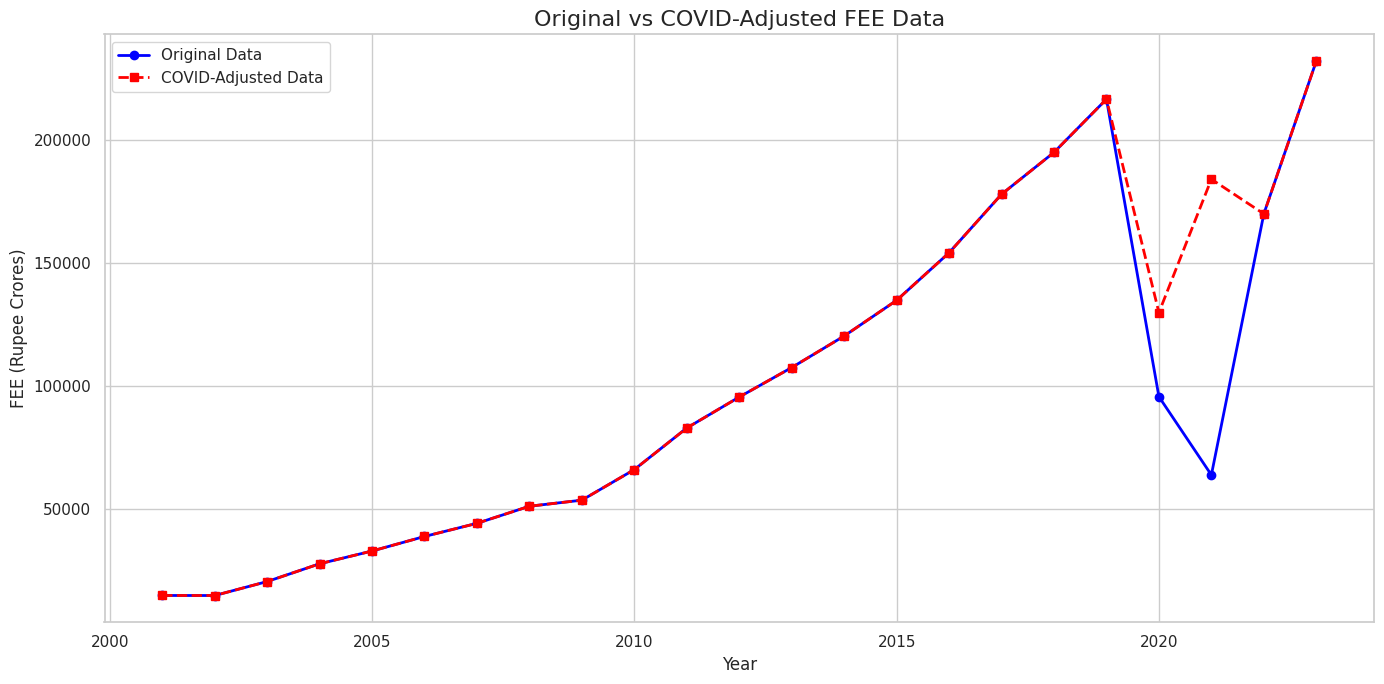

In [50]:
# Create a COVID-adjusted dataset
def create_covid_adjusted_dataset(df_original):
    """Creates a version of the dataset where COVID anomaly is smoothed"""
    df_adjusted = df_original.copy()
    
    # Find indices for pre and post-COVID
    if 2019 in df_adjusted.index and 2020 in df_adjusted.index and 2021 in df_adjusted.index:
        # Calculate a more reasonable value for 2020 based on trend
        pre_covid_value = df_adjusted.loc[2019, 'FEE_Rupee_Crore']
        post_covid_value = df_adjusted.loc[2021, 'FEE_Rupee_Crore']
        
        # Create a smoother transition - 40% drop in 2020 instead of the extreme drop
        adjusted_2020_value = pre_covid_value * 0.6
        
        # Replace the 2020 value
        df_adjusted.loc[2020, 'FEE_Rupee_Crore'] = adjusted_2020_value
        print(f"Adjusted 2020 FEE value from {df_original.loc[2020, 'FEE_Rupee_Crore']} to {adjusted_2020_value}")
        
        # Also adjust 2021 if it's still significantly below trend
        if post_covid_value < pre_covid_value * 0.8:
            adjusted_2021_value = pre_covid_value * 0.85  # 85% recovery
            df_adjusted.loc[2021, 'FEE_Rupee_Crore'] = adjusted_2021_value
            print(f"Adjusted 2021 FEE value from {df_original.loc[2021, 'FEE_Rupee_Crore']} to {adjusted_2021_value}")
    
    return df_adjusted

# Create the adjusted dataset
df_covid_adjusted = create_covid_adjusted_dataset(df_ts)

# Visualize original vs adjusted
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['FEE_Rupee_Crore'], marker='o', linestyle='-', 
         color='blue', label='Original Data', linewidth=2)
plt.plot(df_covid_adjusted.index, df_covid_adjusted['FEE_Rupee_Crore'], marker='s', linestyle='--',
         color='red', label='COVID-Adjusted Data', linewidth=2)
plt.title('Original vs COVID-Adjusted FEE Data', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('FEE (Rupee Crores)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# Find best ARIMA parameters for the adjusted dataset
def find_best_arima_model(df, p_values=[0,1,2], d_values=[0,1], q_values=[0,1,2]):
    """Find the best ARIMA model parameters for the adjusted dataset"""
    best_score = float("inf")
    best_cfg = None
    best_model = None
    
    # Split data for testing
    train_size = int(len(df) * 0.8)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    # Fit model
                    model = ARIMA(train['FEE_Rupee_Crore'], order=order)
                    model_fit = model.fit()
                    
                    # Make prediction
                    predictions = model_fit.forecast(steps=len(test))
                    
                    # Calculate error
                    mse = mean_squared_error(test['FEE_Rupee_Crore'], predictions)
                    rmse = sqrt(mse)
                    
                    # If this is better than the previous best, update
                    if rmse < best_score:
                        best_score = rmse
                        best_cfg = order
                        best_model = model_fit
                        
                    print(f'ARIMA{order} - RMSE: {rmse:.2f}')
                except Exception as e:
                    print(f'Error with ARIMA{order}: {str(e)}')
                    continue
    
    return best_cfg, best_model, best_score

# Find best parameters on adjusted data
print("Finding best ARIMA parameters on COVID-adjusted data...")
best_order, _, _ = find_best_arima_model(df_covid_adjusted)
print(f"Best ARIMA order: {best_order}")

# Fit the final ARIMA model on the full adjusted dataset
adjusted_model = ARIMA(df_covid_adjusted['FEE_Rupee_Crore'], order=best_order)
adjusted_model_fit = adjusted_model.fit()

# Print ARIMA model summary
print("\nARIMA Model Summary:")
print(adjusted_model_fit.summary())

Finding best ARIMA parameters on COVID-adjusted data...
ARIMA(0, 0, 0) - RMSE: 112603.19
ARIMA(0, 0, 1) - RMSE: 101057.51
ARIMA(0, 0, 2) - RMSE: 96105.72
ARIMA(0, 1, 0) - RMSE: 36892.08
ARIMA(0, 1, 1) - RMSE: 38635.37
ARIMA(0, 1, 2) - RMSE: 39457.64
ARIMA(1, 0, 0) - RMSE: 36729.13
ARIMA(1, 0, 1) - RMSE: 38263.17
ARIMA(1, 0, 2) - RMSE: 38964.96
ARIMA(1, 1, 0) - RMSE: 61286.80
ARIMA(1, 1, 1) - RMSE: 70878.84
ARIMA(1, 1, 2) - RMSE: 60386.70
ARIMA(2, 0, 0) - RMSE: 53062.75
ARIMA(2, 0, 1) - RMSE: 51324.40
ARIMA(2, 0, 2) - RMSE: 53674.84
ARIMA(2, 1, 0) - RMSE: 69317.86
ARIMA(2, 1, 1) - RMSE: 69888.29
ARIMA(2, 1, 2) - RMSE: 67413.23
Best ARIMA order: (1, 0, 0)

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:        FEE_Rupee_Crore   No. Observations:                   23
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -269.330
Date:                Sun, 04 May 2025   AIC                            544.660


In [52]:

# Create and fit exponential smoothing model
exp_model = ExponentialSmoothing(
    df_covid_adjusted['FEE_Rupee_Crore'],
    trend='mul',  # Multiplicative trend for exponential growth
    seasonal=None,  # No seasonality in annual data
    initialization_method="estimated"
)
exp_model_fit = exp_model.fit()

# Create a polynomial trend model that can capture the recovery curve
X = np.array(df_covid_adjusted.index).reshape(-1, 1)
y = df_covid_adjusted['FEE_Rupee_Crore'].values

# Create polynomial regression model (degree=2 captures the dip and recovery)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [53]:

# Generate forecasts for the next 5 years
forecast_horizon = 5
last_year = df_covid_adjusted.index[-1]
forecast_years = range(last_year + 1, last_year + forecast_horizon + 1)

# Generate forecasts from each model
arima_forecast = adjusted_model_fit.forecast(steps=forecast_horizon)
exp_forecast = exp_model_fit.forecast(steps=forecast_horizon)

# For polynomial, we need to predict on the future years
future_X = np.array(forecast_years).reshape(-1, 1)
poly_forecast = poly_model.predict(future_X)

# Create a weighted ensemble - custom weights to favor growth-oriented models
ensemble_weights = {
    'ARIMA': 0.25,
    'ExponentialSmoothing': 0.5,  # Higher weight for exp smoothing
    'Polynomial': 0.25
}

# Create the ensemble forecast
ensemble_forecast = []
for i in range(forecast_horizon):
    # Combine the forecasts with weights
    weighted_forecast = (
        arima_forecast[i] * ensemble_weights['ARIMA'] +
        exp_forecast[i] * ensemble_weights['ExponentialSmoothing'] +
        poly_forecast[i] * ensemble_weights['Polynomial']
    )
    ensemble_forecast.append(weighted_forecast)

KeyError: 0